# Importação de Pacotes

In [1]:
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader
import torch.nn as nn

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# Ferramentas para Ciência de Dados
import numpy as np
import pandas as pd
import os


# Manipulação de Imagem
from PIL import Image

# Visualização
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline


# Definição de Constantes Globais

In [30]:
SPLITTED_IMAGES = './splitted_images/'
TRAIN_IMAGES = './splitted_images/train/'
TEST_IMAGES = './splitted_images/test/'

HAS_SPLITTED_IMAGES = len(os.listdir(SPLITTED_IMAGES)) > 0

BATCH_SIZE = 32

IS_CUDA_AVAILABLE = cuda.is_available()

HAS_MULTIPLE_GPU = True if IS_CUDA_AVAILABLE and cuda.device_count() > 1 else False

NUMBER_OF_EPOCHS = 3

DEVICE = 'cuda' if IS_CUDA_AVAILABLE else 'cpu'

MAX_EPOCHS_WITHOUT_IMPROVEMENT = 5

# Pré Processamento de Imagem e Aumento de Dados

In [23]:
# Image transformations

train_transformer = transforms.Compose([
    transforms.RandomResizedCrop(size=200, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=64),  # Image net standards
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Imagenet standards
])

test_transformer = transforms.Compose([
    transforms.Resize(size=64),
    transforms.CenterCrop(size=180),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Preparação dos Datasets das Imagens

In [24]:
# Datasets from each folder
train_datasets = datasets.ImageFolder(root=TRAIN_IMAGES, transform=train_transformer)
test_datasets = datasets.ImageFolder(root=TEST_IMAGES, transform=test_transformer)

# Class Mappers
class_to_idx = train_datasets.class_to_idx
idx_to_class = {
    idx: class_ for class_, idx in class_to_idx.items()
}

# Dataloader iterators
train_datasets_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, shuffle=True)
test_datasets_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, shuffle=True)

# Carregamento do Modelo VGG16 com ou sem pré treinamento.

In [11]:
def get_vgg16(pretrained:bool=True):
    vgg16_model = models.vgg16(pretrained=pretrained)

    vgg16_model.class_to_idx = class_to_idx
    vgg16_model.idx_to_class = idx_to_class

    vgg16_model.classifier[6] = nn.Linear(in_features=4096, out_features=21)

    if IS_CUDA_AVAILABLE:
        vgg16_model = vgg16_model.to('cuda')
    
    return vgg16_model

/home/vjchave/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vjchave/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.weight
0.bias
2.weight
2.bias
5.weight
5.bias
7.weight
7.bias
10.weight
10.bias
12.weight
12.bias
14.weight
14.bias
17.weight
17.bias
19.weight
19.bias
21.weight
21.bias
24.weight
24.bias
26.weight
26.bias
28.weight
28.bias


# Definição da Função de Perda

In [26]:
cross_entropy_criterion = nn.CrossEntropyLoss() 

# Definição do Otimizador

In [12]:
def get_simple_optimizer(model:models.VGG):
    return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def get_partial_thawed_optimizer(model:models.VGG):
    for param in model.features.parameters():
        param.requires_grad = False

    for param in model.features.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True

    parameters_to_optimize = filter(lambda param: param.requires_grad, model.parameters())
        
    return optim.SGD(parameters_to_optimize, lr=0.001, momentum=0.9)

def get_fully_thawed_optimizer(model:models.VGG):
    for param in model.features.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True

    for name, param in model.features.named_parameters():
        if '28' in name:
            param.requires_grad = True

    parameters_to_optimize = filter(lambda param: param.requires_grad, model.parameters())

    return optim.SGD(parameters_to_optimize, lr=0.001, momentum=0.9)

# Definição do Treinamento

In [32]:
def train_vgg16_model(vgg16_model:models.VGG, optimizer:optim.SGD, file_name:str):
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []
    
    epochs_without_improve = 0
  
    minimum_test_loss = np.Inf
  
    for epoch in range(NUMBER_OF_EPOCHS):
        vgg16_model.train()

        train_loss = 0.0
        test_loss = 0.0

        train_accuracy = 0
        test_accuracy = 0

        for images, labels in tqdm(train_datasets_loader, desc=f'(train) Epoch {epoch+1}/{NUMBER_OF_EPOCHS}', unit='batch'):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = vgg16_model(images)
            
            loss = cross_entropy_criterion(outputs, labels)
            
            train_loss += loss.item() * images.size(0)
            
            _, prediction = torch.max(outputs, dim=1)

            correct_tensor = prediction.eq(labels.data.view_as(prediction))

            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            train_accuracy += accuracy.item() * images.size(0)
            
            loss.backward()
            
            optimizer.step()

        vgg16_model.eval()  # Muda o modelo para o modo de avaliação

        for images, labels in tqdm(test_datasets_loader, desc=f'(valid) Epoch {epoch+1}/{NUMBER_OF_EPOCHS}', unit='batch'):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():  # Desativar o cálculo dos gradientes durante a fase de teste
                outputs = vgg16_model(images)
                
                loss = cross_entropy_criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0)
        
                _, prediction = torch.max(outputs, dim=1)
                correct_tensor = prediction.eq(labels.data.view_as(prediction))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

                test_accuracy += accuracy.item() * images.size(0)

        
        train_loss = train_loss / len(train_datasets_loader.dataset)
        test_loss = test_loss / len(test_datasets_loader.dataset)

        # Calculate average accuracy
        train_accuracy = train_accuracy / len(train_datasets_loader.dataset)
        test_accuracy = test_accuracy / len(test_datasets_loader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if test_loss < minimum_test_loss:
            torch.save(vgg16_model.state_dict(), file_name)
            epochs_without_improve = 0
            minimum_test_loss = test_loss

        # Otherwise increment count of epochs with no improvement
        else:
            epochs_without_improve += 1
            # Trigger early stopping
            if epochs_without_improve >= MAX_EPOCHS_WITHOUT_IMPROVEMENT:
                # Load the best state dict
                vgg16_model.load_state_dict(torch.load(file_name))

                break

    return {
            'model': vgg16_model,
            'train': {
                'losses': train_losses,
                'accuracies': train_accuracies,
            },
            'valid': {
                'losses': test_losses,
                'accuracies': test_accuracies,
            }
        }

# Treinamento From Scratch sem Pré Treinamento

In [28]:
vgg16_model = get_vgg16(pretrained=False)

simple_optimizer = get_simple_optimizer(vgg16_model)

untrained_results = train_vgg16_model(vgg16_model, simple_optimizer)

/home/vjchave/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vjchave/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Test of model: 100%|██████████| 42/42 [00:04<00:00,  9.60batch/s]

Average Test Loss: 3.0207525889078775


# Treinamento Parcialmente Congelado

In [ ]:
vgg16_model = get_vgg16(pretrained=True)

partial_thawed_optimizer = get_partial_thawed_optimizer(vgg16_model)

partial_thawed_results = train_vgg16_model(vgg16_model, partial_thawed_optimizer)

# Treinamento Completamente Congelado

In [ ]:
vgg16_model = get_vgg16(pretrained=True)

fully_thawed_optimizer = get_fully_thawed_optimizer(vgg16_model)

fully_thawed_results = train_vgg16_model(vgg16_model, fully_thawed_optimizer)

# Definição do Método de Gráfico de Linha

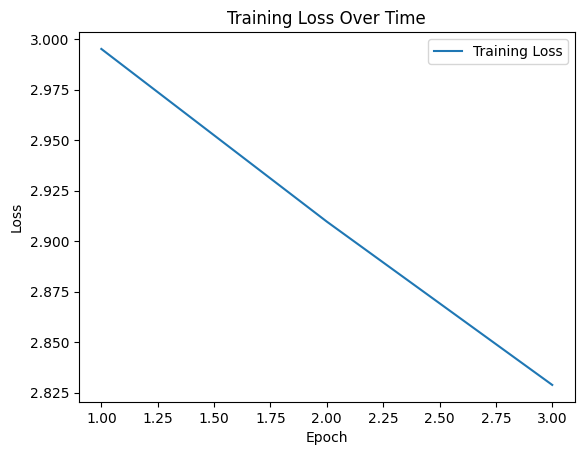

In [11]:
def plot_line(data:list[float], label:str, title:str):
    plt.plot(range(1, NUMBER_OF_EPOCHS+1), data, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()